In [46]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import datasets, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [24]:
poems_dt = pd.read_csv('/opt/data/poems.csv', sep=';') # text in column 4, classifier in column 3.
X = poems_dt.values[:,3]
y = poems_dt.values[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
class PorterStemmedCountVectorizer(CountVectorizer):
    _stemmer = PorterStemmer()
    
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: ([self._stemmer.stem(w) for w in analyzer(doc)])


class SnowballStemmedCountVectorizer(CountVectorizer):
    _stemmer = SnowballStemmer("english", ignore_stopwords=True)
        
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: ([self._stemmer.stem(w) for w in analyzer(doc)])


class LemmaCountVectorizer(CountVectorizer):
    _lemma = WordNetLemmatizer()

    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: ([self._lemma.lemmatize(w) for w in analyzer(doc)])

vectorizers = {
    "no_preprocesing": ('vect', CountVectorizer()),
    "porter_stemmer": ('vect', PorterStemmedCountVectorizer()),
    "snowball_stemmer": ('vect', SnowballStemmedCountVectorizer()),
    "wordcount_lemma": ('vect', LemmaCountVectorizer()),
}

In [26]:
def best_params(pipelines, parameters):
    def _best_params(clf):
        gs_clf = GridSearchCV(clf, parameters, n_jobs=-1, scoring='f1_macro')
        gs_clf.fit(X_train, y_train)
        print("Best parameters set found on development set:\n")
        print(gs_clf.best_params_)
        print("Grid scores on development set:\n")
        means = gs_clf.cv_results_['mean_test_score']
        stds = gs_clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gs_clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print("Detailed classification report:\n")
        y_true, y_pred = y_test, gs_clf.predict(X_test)
        print(metrics.classification_report(y_true, y_pred))
    
    for n, p in pipelines.items():
        print(f"#### Tuning hyper-parameters with {n}:\n")
        _best_params(p)


def model_evaluation(pipelines):
    def _model_evaluation(clf):
        clf.fit(X_train, y_train)
        predicted = clf.predict(X_test)
        print("Report:\n")
        print(metrics.classification_report(y_test, predicted, target_names=np.unique(y)))

    for n, p in pipelines.items():
        print(f"#### Model evaluation with {n}:\n")
        _model_evaluation(p)

## KNeighborsClassifier

In [39]:
kn_pipelines = {
    n: Pipeline([
        v,
        ('tfidf', TfidfTransformer()),
        ('smplr', RandomOverSampler()),
        ('clf', KNeighborsClassifier())
    ]) for n, v in vectorizers.items()
}

kn_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': (None, 'english'),
    'tfidf__use_idf': (True, False),
    'clf__n_neighbors': (3, 4, 5, 6),
}

###  Model evaluation

[[0.58333333 0.15277778 0.03472222 0.22916667]
 [0.15510204 0.50204082 0.06938776 0.27346939]
 [0.02281369 0.20152091 0.19391635 0.58174905]
 [0.0171184  0.07560628 0.08559201 0.82168331]]


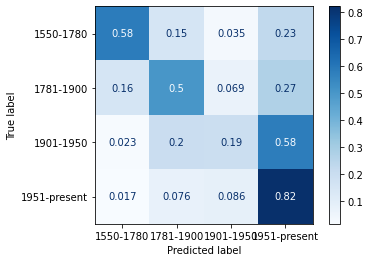

In [48]:
clf = Pipeline([
    ('vect', PorterStemmedCountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('smplr', RandomOverSampler()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])
clf.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=np.unique(y), cmap=plt.cm.Blues, normalize='true')
print(disp.confusion_matrix)
plt.show()

### Best params

In [40]:
best_params(kn_pipelines, kn_parameters)

#### Tuning hyper-parameters with wordcount_lemma:

Best parameters set found on development set:

{'clf__n_neighbors': 3, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Grid scores on development set:

0.421 (+/-0.060) for {'clf__n_neighbors': 3, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.456 (+/-0.039) for {'clf__n_neighbors': 3, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.403 (+/-0.023) for {'clf__n_neighbors': 3, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.447 (+/-0.031) for {'clf__n_neighbors': 3, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
Detailed classification report:

              precision    recall  f1-score   support

   1550-1780       0.49      0.61      0.54       144
   1781-1900       0.32      0.46      0.38       245
   1901-1950       0.17      0.17      0.17       263
19

## SGDClassifier

In [31]:
sgd_pipelines = {
    n: Pipeline([
        v,
        ('tfidf', TfidfTransformer()),
        ('smplr', RandomOverSampler()),
        ('clf', SGDClassifier())
    ]) for n, v in vectorizers.items()
}
sgd_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': (None, 'english'),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.0001, 0.001, 0.01, 0.1, 1, 10, 100),
}

###  Model evaluation

[[0.80555556 0.11111111 0.04166667 0.04166667]
 [0.08163265 0.68163265 0.15918367 0.07755102]
 [0.03802281 0.17870722 0.3878327  0.39543726]
 [0.00190204 0.00665716 0.03756538 0.95387542]]


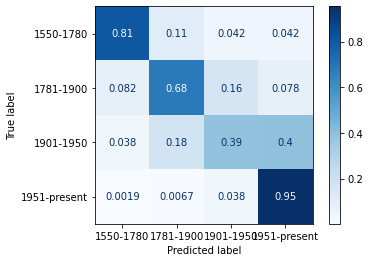

In [49]:
clf = Pipeline([
    ('vect', LemmaCountVectorizer(stop_words=None)),
    ('tfidf', TfidfTransformer()),
    ('smplr', RandomOverSampler()),
    ('clf', SGDClassifier(alpha=0.0001))
])
clf.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=np.unique(y), cmap=plt.cm.Blues, normalize='true')
print(disp.confusion_matrix)
plt.show()

### Best params

In [32]:
best_params(sgd_pipelines, sgd_parameters)

#### Tuning hyper-parameters with no_preprocesing:

Best parameters set found on development set:

{'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
Grid scores on development set:

0.698 (+/-0.030) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.678 (+/-0.018) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.670 (+/-0.026) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
0.656 (+/-0.015) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
0.668 (+/-0.028) for {'clf__alpha': 0.0001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.660 (+/-0.030) for {'clf__alpha': 0.0001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.678 (+/-0

              precision    recall  f1-score   support

   1550-1780       0.77      0.83      0.80       144
   1781-1900       0.67      0.67      0.67       245
   1901-1950       0.46      0.44      0.45       263
1951-present       0.95      0.95      0.95      2103

    accuracy                           0.87      2755
   macro avg       0.71      0.72      0.72      2755
weighted avg       0.87      0.87      0.87      2755

#### Tuning hyper-parameters with snowball_stemmer:

Best parameters set found on development set:

{'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
Grid scores on development set:

0.695 (+/-0.032) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.681 (+/-0.018) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.679 (+/-0.029) for {'clf__alpha': 0.0001, 'tfidf__use_idf': True, 'vect__ngra

              precision    recall  f1-score   support

   1550-1780       0.78      0.80      0.79       144
   1781-1900       0.68      0.66      0.67       245
   1901-1950       0.47      0.41      0.44       263
1951-present       0.94      0.96      0.95      2103

    accuracy                           0.87      2755
   macro avg       0.72      0.71      0.71      2755
weighted avg       0.86      0.87      0.87      2755



## MultinomialNB

In [28]:
mnb_pipelines = {
    n: Pipeline([
        v,
        ('tfidf', TfidfTransformer()),
        ('smplr', RandomOverSampler()),
        ('clf', MultinomialNB())
    ]) for n, v in vectorizers.items()
}
mnb_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': (None, 'english'),
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1, 0.5, 0.1, 0.01, 0.001),
}

### Model evaluation

[[0.88888889 0.09027778 0.01388889 0.00694444]
 [0.09387755 0.75102041 0.12244898 0.03265306]
 [0.04562738 0.24714829 0.40304183 0.30418251]
 [0.00332858 0.01569187 0.04469805 0.9362815 ]]


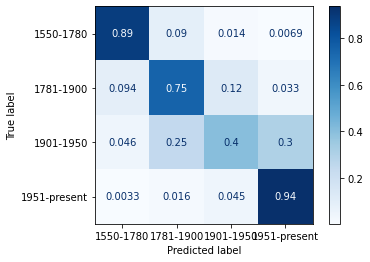

In [50]:
clf = Pipeline([
    ('vect', LemmaCountVectorizer(stop_words=None)),
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('smplr', RandomOverSampler()),
    ('clf', MultinomialNB(alpha=0.1))
])
clf.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=np.unique(y), cmap=plt.cm.Blues, normalize='true')
print(disp.confusion_matrix)
plt.show()

### Best params

In [29]:
best_params(mnb_pipelines, mnb_parameters)

#### Tuning hyper-parameters with no_preprocesing:

Best parameters set found on development set:

{'clf__alpha': 0.1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
Grid scores on development set:

0.660 (+/-0.018) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.659 (+/-0.026) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.617 (+/-0.019) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
0.600 (+/-0.018) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
0.631 (+/-0.018) for {'clf__alpha': 1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.654 (+/-0.024) for {'clf__alpha': 1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.610 (+/-0.024) for {'clf__alpha': 1, 'tfi

              precision    recall  f1-score   support

   1550-1780       0.78      0.85      0.81       144
   1781-1900       0.61      0.72      0.66       245
   1901-1950       0.46      0.35      0.39       263
1951-present       0.95      0.95      0.95      2103

    accuracy                           0.87      2755
   macro avg       0.70      0.72      0.70      2755
weighted avg       0.86      0.87      0.86      2755

#### Tuning hyper-parameters with snowball_stemmer:

Best parameters set found on development set:

{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
Grid scores on development set:

0.662 (+/-0.011) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.662 (+/-0.021) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.613 (+/-0.023) for {'clf__alpha': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)

              precision    recall  f1-score   support

   1550-1780       0.75      0.88      0.81       144
   1781-1900       0.62      0.75      0.68       245
   1901-1950       0.45      0.39      0.42       263
1951-present       0.96      0.94      0.95      2103

    accuracy                           0.87      2755
   macro avg       0.69      0.74      0.71      2755
weighted avg       0.87      0.87      0.87      2755



### LinearSVC

In [27]:
svc_pipelines = {
    n: Pipeline([
        v,
        ('tfidf', TfidfTransformer()),
        ('smplr', RandomOverSampler()),
        ('clf', LinearSVC())
    ]) for n, v in vectorizers.items()
}
svc_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__stop_words': (None, 'english'),
    'tfidf__use_idf': (True, False),
    'clf__C': (0.01, 0.1, 1, 5, 10, 50),
}

### Model evaluation

[[0.84722222 0.08333333 0.04166667 0.02777778]
 [0.07755102 0.66938776 0.16326531 0.08979592]
 [0.04562738 0.17870722 0.37642586 0.39923954]
 [0.00285307 0.00618165 0.03756538 0.9533999 ]]


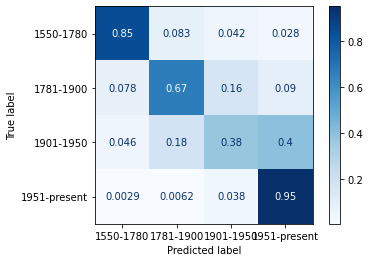

In [51]:
clf = Pipeline([
    ('vect', LemmaCountVectorizer(stop_words=None)),
    ('tfidf', TfidfTransformer()),
    ('smplr', RandomOverSampler()),
    ('clf', LinearSVC(C=0.1))
])
clf.fit(X_train, y_train)
disp = metrics.plot_confusion_matrix(clf, X_test, y_test, display_labels=np.unique(y), cmap=plt.cm.Blues, normalize='true')
print(disp.confusion_matrix)
plt.show()

### Best params

In [30]:
best_params(svc_pipelines, svc_parameters)

#### Tuning hyper-parameters with no_preprocesing:

Best parameters set found on development set:

{'clf__C': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
Grid scores on development set:

0.674 (+/-0.030) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.670 (+/-0.021) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.638 (+/-0.024) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
0.639 (+/-0.021) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}
0.592 (+/-0.020) for {'clf__C': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.645 (+/-0.015) for {'clf__C': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.576 (+/-0.030) for {'clf__C': 0.01, 'tfidf__use_idf'

              precision    recall  f1-score   support

   1550-1780       0.78      0.85      0.81       144
   1781-1900       0.69      0.70      0.70       245
   1901-1950       0.47      0.42      0.44       263
1951-present       0.95      0.95      0.95      2103

    accuracy                           0.87      2755
   macro avg       0.72      0.73      0.73      2755
weighted avg       0.87      0.87      0.87      2755

#### Tuning hyper-parameters with snowball_stemmer:

Best parameters set found on development set:

{'clf__C': 0.1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
Grid scores on development set:

0.679 (+/-0.030) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}
0.677 (+/-0.028) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english'}
0.646 (+/-0.029) for {'clf__C': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2), 'vect__

              precision    recall  f1-score   support

   1550-1780       0.76      0.84      0.80       144
   1781-1900       0.67      0.65      0.66       245
   1901-1950       0.42      0.36      0.39       263
1951-present       0.94      0.95      0.95      2103

    accuracy                           0.86      2755
   macro avg       0.70      0.70      0.70      2755
weighted avg       0.86      0.86      0.86      2755

